In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
# import streamlit as st
from PIL import Image, ImageOps
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set seed for reproducibility
tf.random.set_seed(42)
# Define image size and batch size
IMG_SIZE = (256, 256)  # You can adjust this based on your dataset
BATCH_SIZE = 32


In [4]:
# Set paths to your dataset (make sure you update this with your dataset path)
TRAIN_DIR = "/content/drive/MyDrive/Teeth_Dataset/Training"
VALIDATION_DIR = "/content/drive/MyDrive/Teeth_Dataset/Validation"
TEST_DIR = "/content/drive/MyDrive/Teeth_Dataset/Testing"


In [20]:
# 1. Preprocessing and Data Augmentation

# Augment training data and normalize images
train_datagen = ImageDataGenerator(
    # rescale=1./255,                # Normalizing the images
    rotation_range=20,             # Random rotation
    width_shift_range=0.2,         # Horizontal shifting
    height_shift_range=0.2,        # Vertical shifting
    shear_range=0.2,               # Shearing transformation
    zoom_range=0.2,                # Random zoom
    horizontal_flip=True,          # Flipping the images
    fill_mode='nearest'            # Fill mode
)

# Only normalize validation and test data
validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()


In [21]:
def count_images_per_class(directory):
    class_counts = {}
    excluded_folders = []
    if directory == '/content/drive/MyDrive/Teeth_Dataset/Testing':
      excluded_folders.append('out')
      excluded_folders.append('output')
      excluded_folders.append('outputs')

    for class_name in os.listdir(directory):
        if class_name in excluded_folders:
            continue
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    return class_counts

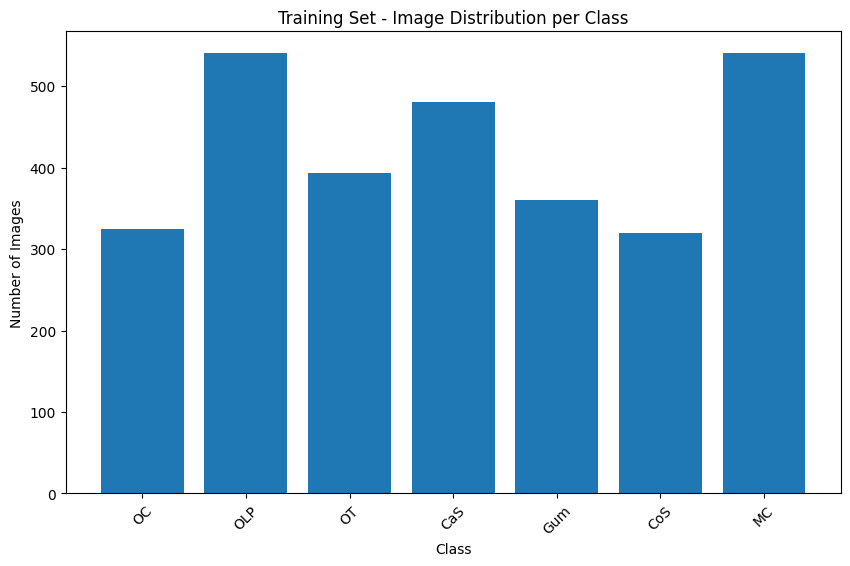

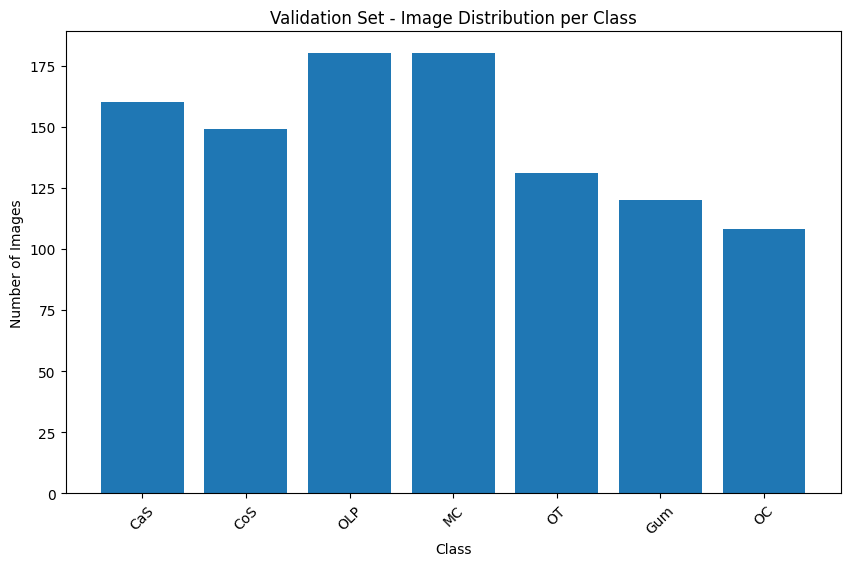

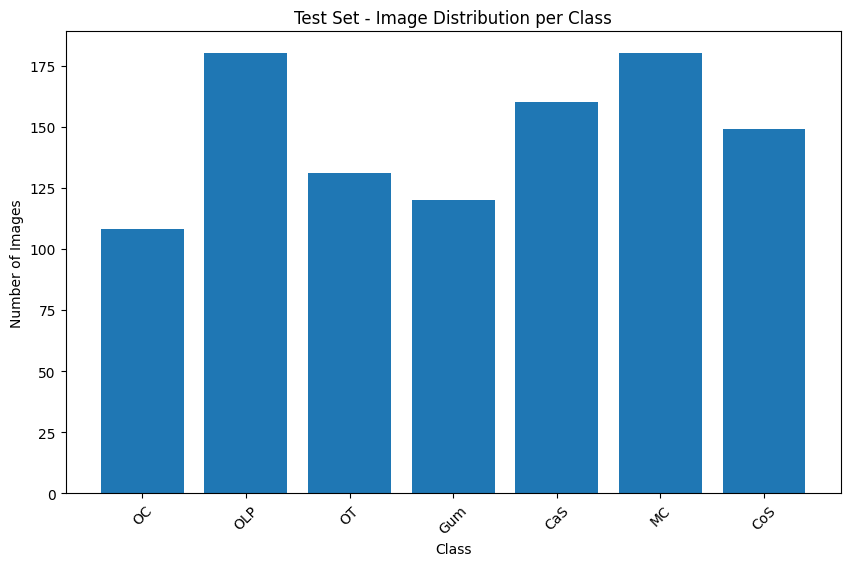

In [22]:
# Count images per class for each dataset split
train_class_counts = count_images_per_class(TRAIN_DIR)
validation_class_counts = count_images_per_class(VALIDATION_DIR)
test_class_counts = count_images_per_class(TEST_DIR)

# Visualize the counts for each split
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.title(f'{title} - Image Distribution per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Plot the class distributions
plot_class_distribution(train_class_counts, 'Training Set')
plot_class_distribution(validation_class_counts, 'Validation Set')
plot_class_distribution(test_class_counts, 'Test Set')

In [23]:
# Flow training images in batches using the generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Assuming multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2957 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


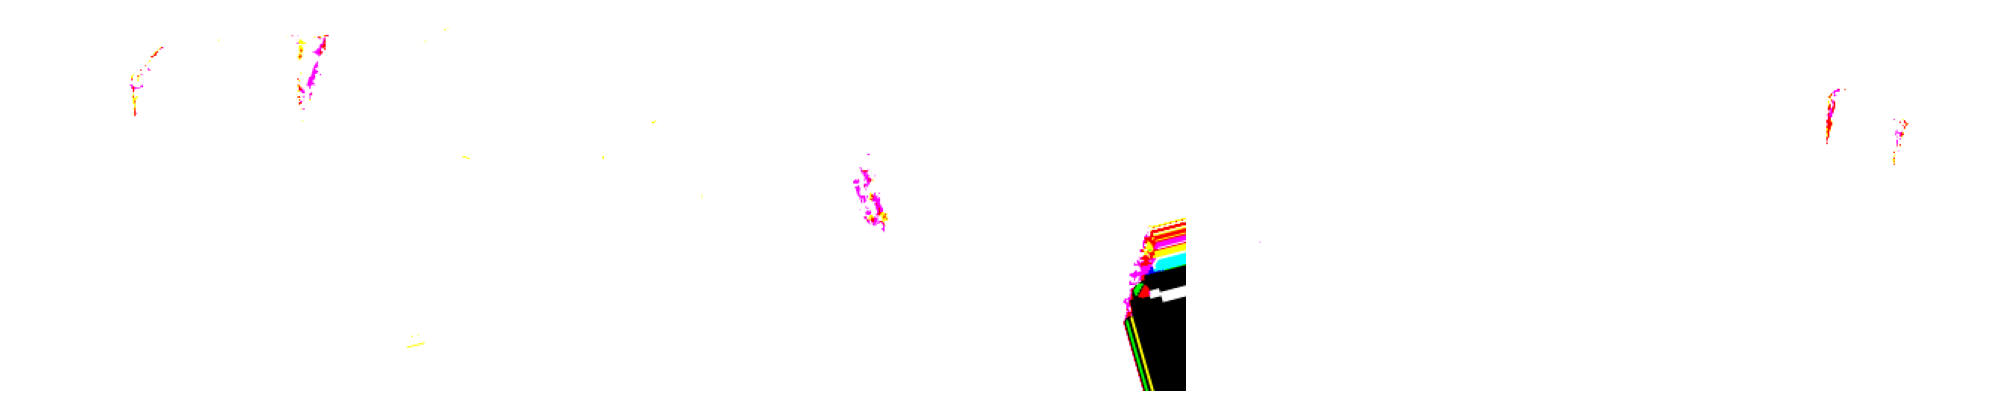

In [24]:
# 2. Visualizing the Dataset (Optional but Useful)

# Visualizing augmented images
sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Display 5 sample images

In [25]:
sample_training_images, _ = next(train_generator)
sample_training_images[0].shape

(256, 256, 3)

In [26]:
# Load EfficientNetB0 with pre-trained ImageNet weights
base_model = EfficientNetB0(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
# This is the base convolutional neural network (CNN) model pre-trained on the ImageNet dataset, which contains millions of images across thousands of categories.
# include_top=False: Excludes the top (final) classification layers of the model. This allows us to add our own custom classification layers suited to our specific task.
# weights='imagenet': Initializes the model with weights pre-trained on the ImageNet dataset, leveraging transfer learning.



# Freeze the base model
base_model.trainable = False
# Setting base_model.trainable = False ensures that the weights of the pre-trained EfficientNetB0 model
# remain unchanged during the initial training phase. This allows the model to leverage the learned features
# from ImageNet without altering them, which is especially useful when you have a limited dataset.



# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # 7 classes for 7 diseases
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [27]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# EarlyStopping:
# Callbacks: Functions that are called during training at specific points (e.g., at the end of each epoch).
# EarlyStopping:  Monitors a validation metric and stops training if it doesn't improve for a specified number of epochs.
# Purpose: Stops training when a monitored metric has stopped improving.
# patience=5: Waits for 5 epochs without improvement before stopping.
# restore_best_weights=True: Restores the model weights from the epoch with the best monitored metric.

model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# ModelCheckpoint:
# Purpose: Saves the model after every epoch if the monitored metric improves.


# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 94s 757ms/step - accuracy: 0.4028 - loss: 1.5491 - val_accuracy: 0.7393 - val_loss: 0.7856
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 59s 597ms/step - accuracy: 0.6448 - loss: 0.9491 - val_accuracy: 0.8191 - val_loss: 0.5892
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 596ms/step - accuracy: 0.7377 - loss: 0.7437 - val_accuracy: 0.8599 - val_loss: 0.4457
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 592ms/step - accuracy: 0.7885 - loss: 0.6272 - val_accuracy: 0.9027 - val_loss: 0.3703
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 583ms/step - accuracy: 0.8093 - loss: 0.5622 - val_accuracy: 0.9183 - val_loss: 0.3009
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 588ms/step - accuracy: 0.8429 - loss: 0.4688 - val_accuracy: 0.9329 - val_loss: 0.2601
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 82s 587ms/step - accuracy: 0.8447 - loss: 0.4364 - val_accuracy: 0.9154 - val_loss: 0.2635
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 611ms/step - accuracy: 0.8804 - loss: 0.3665 - val_accuracy: 0.947

In [28]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True  #This enables the model to fine-tune the pre-trained weights to better fit the specific features of your dataset.

# Re-compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.3558 - loss: 2.6440 - val_accuracy: 0.8541 - val_loss: 0.4567
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 107s 620ms/step - accuracy: 0.4576 - loss: 1.8929 - val_accuracy: 0.7451 - val_loss: 0.7183
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 614ms/step - accuracy: 0.5403 - loss: 1.5183 - val_accuracy: 0.7675 - val_loss: 0.6779
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 84s 626ms/step - accuracy: 0.6056 - loss: 1.1931 - val_accuracy: 0.7947 - val_loss: 0.6015
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 61s 617ms/step - accuracy: 0.6475 - loss: 1.1073 - val_accuracy: 0.8103 - val_loss: 0.5497


In [29]:
# Load the best model saved during training
model.load_weights('best_model.keras')

# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 432 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


33/33 ━━━━━━━━━━━━━━━━━━━━ 349s 11s/step - accuracy: 0.9841 - loss: 0.0530
Test accuracy: 0.9786


In [35]:
# Predict the labels for the test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

y_true = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(class_report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step
Confusion Matrix:
[[141   1   2   3   6   4   3]
 [  0 128   3  17   1   0   0]
 [  0   0 120   0   0   0   0]
 [  0   0  37 126  12   5   0]
 [  0   0   1   2 105   0   0]
 [  1   0   2   1  18 158   0]
 [  0   0   3   2   3   3 120]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       160
           1       0.99      0.86      0.92       149
           2       0.71      1.00      0.83       120
           3       0.83      0.70      0.76       180
           4       0.72      0.97      0.83       108
           5       0.93      0.88      0.90       180
           6       0.98      0.92      0.94       131

    accuracy                           0.87      1028
   macro avg       0.88      0.89      0.88      1028
weighted avg       0.89      0.87      0.88      1028



In [30]:
# Save the model for later deployment with Streamlit
model.save('teeth_disease_classifier.h5')


In [ ]:
# Load the model
model = tf.keras.models.load_model('teeth_disease_classifier.h5')

def preprocess_image(image):
    size = (256, 256)  # Image size to match model input
    image = ImageOps.fit(image, size, method=Image.Resampling.LANCZOS)
    image = np.asarray(image)


    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    print('#'*30)
    print(image.shape)
    print(image)
    print('#'*30)
    return image
# Streamlit app
st.write("# Teeth Disease Classifier")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Preprocess the image
    img = preprocess_image(image)

    # Make prediction
    prediction = model.predict(img)

    # Define class names according to your model's output
    class_names = ['Disease 1', 'Disease 2', 'Disease 3', 'Disease 4', 'Disease 5', 'Disease 6', 'Disease 7']

    # Display the prediction
    print(prediction)
    st.write(f"Prediction: {class_names[np.argmax(prediction)]}")
